In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV 
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("Data/Residential-Building-Data-Set.csv", header = 1)

In [3]:
df.head()

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,...,V-22.4,V-23.4,V-24.4,V-25.4,V-26.4,V-27.4,V-28.4,V-29.4,V-9,V-10
0,81.0,1.0,85.0,1.0,1.0,3150.0,920.0,598.5,190.0,1010.84,...,815.50,1755.00,8002.0,60.74,54.26,2978.26,41407.0,601988.1,2200.0,410.0
1,84.0,1.0,89.0,4.0,1.0,7600.0,1140.0,3040.0,400.0,963.81,...,1316.30,8364.78,8393.0,90.95,89.79,11379.37,44835.0,929027.1,5000.0,1000.0
2,78.0,1.0,81.0,4.0,1.0,4800.0,840.0,480.0,100.0,689.84,...,765.80,1755.00,4930.0,38.70,32.04,1653.06,37933.0,377828.6,1200.0,170.0
3,72.0,2.0,73.0,2.0,1.0,685.0,202.0,13.7,20.0,459.54,...,152.25,1442.31,1456.0,9.73,8.34,686.16,8194.0,122031.7,165.0,30.0
4,87.0,1.0,90.0,2.0,1.0,3000.0,800.0,1230.0,410.0,631.91,...,2244.10,9231.76,9286.0,136.60,140.20,9821.00,48260.0,1734973.5,5500.0,700.0


In [4]:
print(df.shape)
print(df.describe())

(372, 109)
       START YEAR  START QUARTER  COMPLETION YEAR  COMPLETION QUARTER  \
count  372.000000     372.000000       372.000000          372.000000   
mean    81.483871       2.190860        82.951613            2.586022   
std      4.182141       1.083382         4.223898            1.123442   
min     72.000000       1.000000        73.000000            1.000000   
25%     78.000000       1.000000        80.000000            2.000000   
50%     82.000000       2.000000        84.000000            3.000000   
75%     85.000000       3.000000        87.000000            4.000000   
max     88.000000       4.000000        90.000000            4.000000   

              V-1           V-2          V-3          V-4         V-5  \
count  372.000000    372.000000   372.000000   372.000000  372.000000   
mean     9.728495   1729.044355   426.114247   327.904086  163.118280   
std      6.563309   1802.371491   490.076498   563.544337  112.604343   
min      1.000000    200.000000    60.0

- Split Data into X and y subsets. X being the entire data frame without V-9 and V-10 and y being the target column of V-10. 
- We removed V-9 because it is the final sales price which can leak data about V-10 which violates our ML golden rule

In [5]:
X = df.drop(columns = ['V-9', 'V-10'])
y = df['V-10']

Split data into #80 , #20 Training, testing split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state = 42)

Performing Exploratory Data Analysis

Text(0, 0.5, 'Frequency')

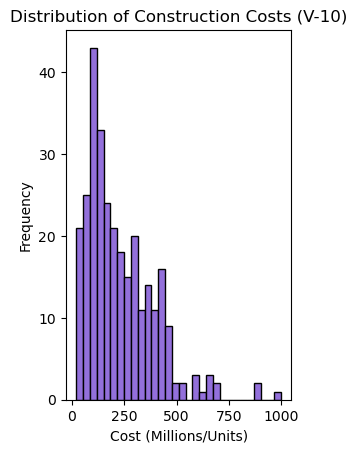

In [7]:
# Plot A: Target Distribution (Histogram)
# This shows if costs are normally distributed or skewed.
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='mediumpurple', edgecolor='black')
plt.title("Distribution of Construction Costs (V-10)")
plt.xlabel("Cost (Millions/Units)")
plt.ylabel("Frequency")

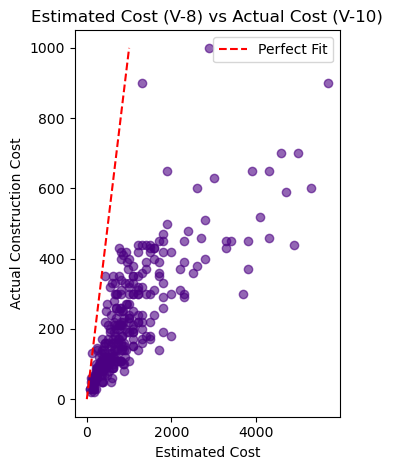

In [8]:
# Plot B: Scatter Plot
# This checks the relationship between Estimate (V-8) and Actual (V-10).
# If the dots follow the red line, the estimate is a good predictor.
plt.subplot(1, 2, 2)
plt.scatter(X_train['V-8'], y_train, alpha=0.6, color='indigo')
plt.plot([0, y_train.max()], [0, y_train.max()], 'r--', label='Perfect Fit')
plt.title("Estimated Cost (V-8) vs Actual Cost (V-10)")
plt.xlabel("Estimated Cost")
plt.ylabel("Actual Construction Cost")
plt.legend()

plt.tight_layout()
plt.show()

Synthetic Data Generation using Kernel Density Estimation 

Based off of this plot we're seeing that estimations are generally being pretty well predictors to the actual costs based on the trend of the data. There are however outliers. 

Next phase is creating our synthetic data

In [9]:
#Prepare Data
train_data_combined = pd.concat([X_train, y_train], axis = 1)
scaler_gen = StandardScaler()
trained_data_scaled = scaler_gen.fit_transform(train_data_combined)

In [10]:
#Fit inside Generator
kde = KernelDensity(kernel ='gaussian', bandwidth = 0.5)
kde.fit(trained_data_scaled)
kde

,bandwidth,0.5
,algorithm,'auto'
,kernel,'gaussian'
,metric,'euclidean'
,atol,0
,rtol,0
,breadth_first,True
,leaf_size,40
,metric_params,None


In [11]:
#Generate 300 new samples
synthetic_scaled = kde.sample(300, random_state = 42)
synthetic_data = scaler_gen.inverse_transform(synthetic_scaled)

In [12]:
# 4. Convert back to DataFrame
# We need to make sure the column names match our original data.
synthetic_df = pd.DataFrame(synthetic_data, columns=train_data_combined.columns)
X_synthetic = synthetic_df.drop(columns=['V-10'])
y_synthetic = synthetic_df['V-10']


In [13]:
#Combine synthetic data with training set

X_final = pd.concat([X_train, X_synthetic], axis=0)
y_final = pd.concat([y_train, y_synthetic], axis=0)

X_final

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,...,V-20.4,V-21.4,V-22.4,V-23.4,V-24.4,V-25.4,V-26.4,V-27.4,V-28.4,V-29.4
192,73.000000,2.000000,74.000000,3.000000,8.000000,510.000000,160.000000,15.300000,30.000000,654.640000,...,12.000000,183.600000,211.100000,1612.950000,1649.000000,11.620000,10.060000,392.960000,8435.750000,1.415426e+05
75,73.000000,4.000000,75.000000,2.000000,3.000000,580.000000,150.000000,17.400000,30.000000,631.890000,...,12.000000,170.300000,217.200000,1657.660000,1759.000000,12.610000,11.030000,354.550000,25307.250000,1.551817e+05
84,76.000000,4.000000,78.000000,1.000000,3.000000,1710.000000,440.000000,119.700000,70.000000,525.490000,...,15.000000,412.000000,768.000000,1755.000000,4630.000000,31.300000,23.870000,1991.430000,27613.500000,4.138345e+05
360,86.000000,2.000000,87.000000,3.000000,20.000000,1370.000000,360.000000,191.800000,140.000000,271.210000,...,14.000000,1763.900000,1837.400000,9153.660000,9168.000000,120.240000,121.940000,9576.900000,12065.000000,1.673301e+06
16,86.000000,3.000000,87.000000,4.000000,1.000000,1460.000000,380.000000,627.800000,430.000000,733.240000,...,14.000000,1994.600000,2025.000000,9185.480000,9208.000000,123.370000,127.330000,9501.300000,24130.000000,1.660444e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,81.017613,2.047345,88.139829,0.550353,9.175906,1822.799806,146.014154,542.513491,406.259148,908.111752,...,14.046867,1597.316246,2018.405007,7648.172029,8582.891176,129.166517,153.566476,11155.028997,20293.670765,1.594494e+06
296,81.024236,4.039311,87.783222,0.830818,12.465683,2100.735957,411.144834,559.948841,126.205993,256.371511,...,13.632628,1786.581651,1203.243759,9561.354726,9277.777807,110.817839,125.193401,10738.841739,33368.050423,1.643727e+06
297,86.583241,1.584284,88.380592,2.163294,13.541668,423.557464,-55.676602,5.774103,148.749621,574.545400,...,14.521835,1734.291848,1478.387289,11083.774827,9424.599698,137.009048,123.115819,13729.294577,45162.495584,1.948067e+06
298,82.952362,1.145942,87.970297,2.573529,3.368284,2822.759342,573.538456,1273.381332,373.826246,745.757308,...,14.244228,2277.872148,2486.179174,10054.962934,6361.283051,154.364927,157.627833,9049.803961,35094.496735,1.796138e+06


Creating Final ML model. This will be a Linear regression ridge model

In [15]:
#For ridge data must be scaled

scaler_model = StandardScaler()
X_final_scaled = scaler_model.fit_transform(X_final)
X_test_scaled = scaler_model.transform(X_test)

In [16]:
#rain Ridge (with Cross Validation)
# cv=5 means it checks its work 5 times to find the best settings (alpha).
ridge = RidgeCV(cv=5) 
ridge.fit(X_final_scaled, y_final)

,alphas,"(0.1, ...)"
,fit_intercept,True
,scoring,None
,cv,5
,gcv_mode,None
,store_cv_results,False
,alpha_per_target,False


In [17]:
#predict on testing data
y_pred = ridge.predict(X_test_scaled)

In [19]:
#get mean absolute error and r2 score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mae)
print(r2)

32.4826219881645
0.940698647569737


In [20]:
print("-" * 30)
print(f"Final Ridge Model MAE: {mae:.2f}")
print(f"Final Ridge Model R2:  {r2:.4f}")
print(f"Best Penalty Strength (Alpha): {ridge.alpha_}")
print("-" * 30)

------------------------------
Final Ridge Model MAE: 32.48
Final Ridge Model R2:  0.9407
Best Penalty Strength (Alpha): 10.0
------------------------------


In [22]:
# Feature Importance
coef_df = pd.DataFrame({'Feature': X.columns, 'Weight': ridge.coef_})
coef_df['Impact'] = coef_df['Weight'].abs()
top_drivers = coef_df.sort_values(by='Impact', ascending=False).head(10)

print(top_drivers)

    Feature     Weight     Impact
8       V-5  52.314872  52.314872
106  V-29.4  32.421464  32.421464
9       V-6  29.114508  29.114508
10      V-7  24.729516  24.729516
7       V-4  24.672358  24.672358
17     V-16  23.690750  23.690750
11      V-8  21.119535  21.119535
84   V-26.3 -20.168995  20.168995
16     V-15 -20.075595  20.075595
60   V-21.2  16.416691  16.416691


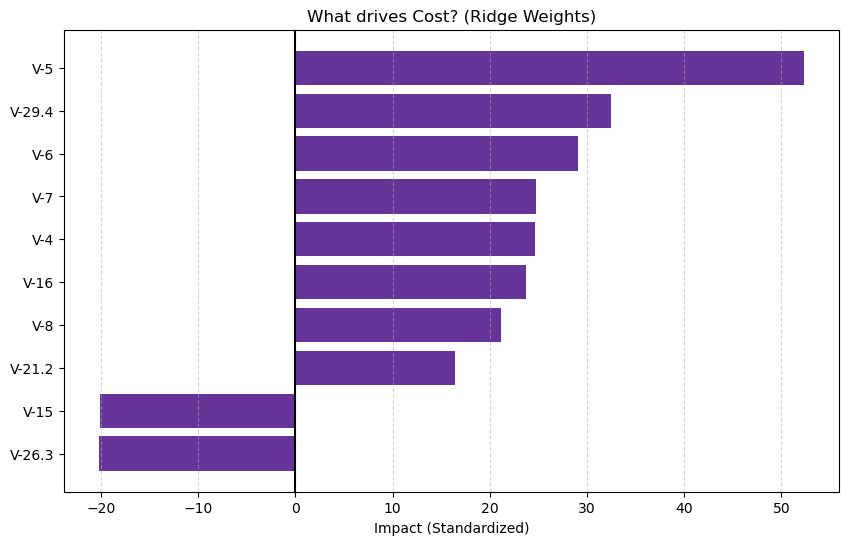

In [23]:
# Plot Weights
plt.figure(figsize=(10, 6))
top_drivers_sorted = top_drivers.sort_values(by='Weight')
plt.barh(top_drivers_sorted['Feature'], top_drivers_sorted['Weight'], color='rebeccapurple')
plt.title("What drives Cost? (Ridge Weights)")
plt.xlabel("Impact (Standardized)")
plt.axvline(0, color='black')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()